In [1]:
import sys, os, copy, re, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import matplotlib.backends.backend_pdf
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("whitegrid")
#palette = list(mcolors.TABLEAU_COLORS.keys())
#palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
palette = sns.color_palette(as_cmap=True)

### Define the compounds we are interested in

In [2]:
# All the amino acids,
# except histidine which does not run well on our LC column
AA_keys = ['Alanine pos', 'Arginine pos', 'Asparagine pos', 'Aspartate neg', 'Cystine pos', 'Glutamate neg', 'Glutamine pos', 'Glycine neg', 'Isoleucine pos', 'Leucine pos', 'Lysine pos', 'Methionine pos', 'Phenylalanine pos', 'Proline pos', 'Serine neg', 'Threonine pos', 'Tryptophan pos', 'Tyrosine pos', 'Valine pos']
# All nucleobases:
GAUCT_keys = ['Guanine pos', 'Adenine pos', 'Uracil neg', 'Cytosine pos', 'Thymine neg', 'Hypoxanthine pos']
# All nucleosides in "pool 14":
pool14_keys = ['Adenosine pos', 'Deoxythymidine neg', 'Deoxycytidine pos', 'Deoxyuridine neg', 'Cytidine pos', 'Guanosine pos', 'Uridine neg']
# Nucleobases resulting from breakdown:
nucl_breakdown_keys = GAUCT_keys + ['Uric acid neg', 'Xanthine neg']

### Read the sample annotations

In [3]:
# Sample annotations relate sample name with
# sample information like treatment, replicate, buffer, internal standard etc.
annotation_df = pd.read_excel('annotations.xlsx')

### Read LCMS data from Excel spreadsheet

In [4]:
### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('nucleotide-digest_acid-hydrolysis_09_18-dec_06-jan.xlsx', sheet_name=None)
metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # Calculate response ratio:
        metab_dict_mes[k]['Response Ratio'] = (metab_dict_mes[k]['Response'] / metab_dict_mes[k]['ISTD Response']).replace(np.inf, 0).replace(np.nan, 0)
        # Add annotations:
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-2] + '_' + fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'ISTD Response', 'Flag Details'], axis=1)

# Extract response ratio:
df_RR = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df_RR['Sample_name']))
    df_RR[nam] = metab_dict_mes[nam]['Response Ratio']
# Extract response (unnormalized peak area):
df_R = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df_R['Sample_name']))
    df_R[nam] = metab_dict_mes[nam]['Response']

In [5]:
df_R

,Sample_name,Replicate,Hydrolysis,Content,Pretreatment,Amount,Exp. name,Buffer,Internal std.,Adenine pos,...,Serine neg,Threonine pos,Thymine neg,Tryptophan pos,Tyrosine pos,Uracil neg,Uric acid neg,Uridine neg,Valine pos,Xanthine neg
0,120920_AH01,1,Acid,Cells,Enzymatic digestion,1AU,Enzyme/acid hydrolysis,MQ,None,2701990594,...,179087086,1796284070,16594674,0,992061078,48806764,3278894,4318457,2718646423,65266937
1,120920_AH02,2,Acid,Cells,Enzymatic digestion,1AU,Enzyme/acid hydrolysis,MQ,None,2357231451,...,161879561,1447987861,19362679,0,984775324,31153025,219489,2555877,2171778349,38339804
2,120920_AH03,1,Acid,Cells,Enzymatic digestion,1AU,Enzyme/acid hydrolysis,Rxn buffer,None,5345228585,...,202779339,2471356625,131572880,0,1329885829,97255988,142283,8863847,3635708712,125607992
3,120920_AH04,2,Acid,Cells,Enzymatic digestion,1AU,Enzyme/acid hydrolysis,Rxn buffer,None,5808824725,...,179070686,1712129785,108605911,0,1046500850,85197409,184598,9675159,2550770390,87926908
4,120920_AH05,1,Acid,Cells,Enzymatic digestion,1AU,Enzyme/acid hydrolysis,10mM NH4Ac,None,2477649957,...,154831872,1608118100,55242409,0,962303399,54189096,170016,1530958,2747583244,87648802
5,120920_AH06,2,Acid,Cells,Enzymatic digestion,1AU,Enzyme/acid hydrolysis,10mM NH4Ac,None,2493610914,...,152248033,1503373026,39997848,172285,947449774,33286116,186491,2311398,2371485824,58167265
6,120920_AH07,1,Acid,Cells,Enzymatic digestion,1AU,Enzyme/acid hydrolysis,100mM NH4Ac,None,4755880776,...,196278290,1696435577,129227320,0,976275547,37847404,187830,3952329,2386235251,51413636
7,120920_AH08,2,Acid,Cells,Enzymatic digestion,1AU,Enzyme/acid hydrolysis,100mM NH4Ac,None,2721393775,...,141268460,1256325263,63188687,0,823323939,21166804,227664,1375800,2007322636,44058934
8,120920_ED01,1,Enzyme,Cells,MeOH quenching,1AU,Enzyme/acid hydrolysis,MQ,YE before hydrolysis,1644287058,...,8956599,305750304,651213206,40393912,74792416,321603982,3189696,405299045,336312871,53169752
9,120920_ED02,2,Enzyme,Cells,MeOH quenching,1AU,Enzyme/acid hydrolysis,MQ,YE before hydrolysis,3187199972,...,9530005,303235313,682718724,24910169,77775140,330298932,4061030,386757110,338762156,51964973


## Looking at amino acid stability
In this experiment the stability of amino acids were tested under acid hydrolysis.
To 9x 1.5 mL eppendorf tubes 20 uL of 500 uM amino acid mix (Sigma: A9906-1ML plus added equimolar glutamine and asparagine, Sigma: 76523-100MG and 51363-100MG) were added. Tubes were dried and 4 were set aside as non-hydrolysis reference points. To the remainding 5 tubes 200 uL 6M HCl (Thermo: 24308) was added and incubated at 100C for 24 h before drying. No attempt was made to evacuate tubes before hydrolysis, thus ambient air was present in the headspace. Finally, all 9 tubes were reconstituted in 40 uL 80% MeOH containing U-13C, U-15N labelled amino acids at ~50 uM each (Cambridge isotopes: MSK-CAA-1) as well as a U-13C yeast extract (Cambridge isotopes: ISO1). The samples were transferred to LCMS vials and quantified on an Orbitrap in full scan mode (m/z=75-850). Peaks were integrated and manually checked in TraceFinder.

In [6]:
# Use a mask to pick out the 9 samples testing amino acid stability:
mask = (df_RR['Exp. name'] == 'Acid stability') & (df_RR['Content'] == 'Amino acid mix')
df_AA = df_RR[mask]
metab_mask = ['Buffer'] + AA_keys
df_metab = df_AA.loc[:, metab_mask]

# Normalize data to the reference (non-hydrolysis) samples:
metab_mask = ['Buffer']
for metab in AA_keys:
    mask_MQ = df_metab['Buffer'] == 'MQ'
    metab_name = metab[0:-4]
    metab_MQ_mean = df_metab.loc[mask_MQ, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_MQ_mean
    metab_mask.append(metab_name)
df_metab = df_metab.loc[:, metab_mask]
# Flatten for plotting:
df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Amino acid', 'value': 'Peak area'})

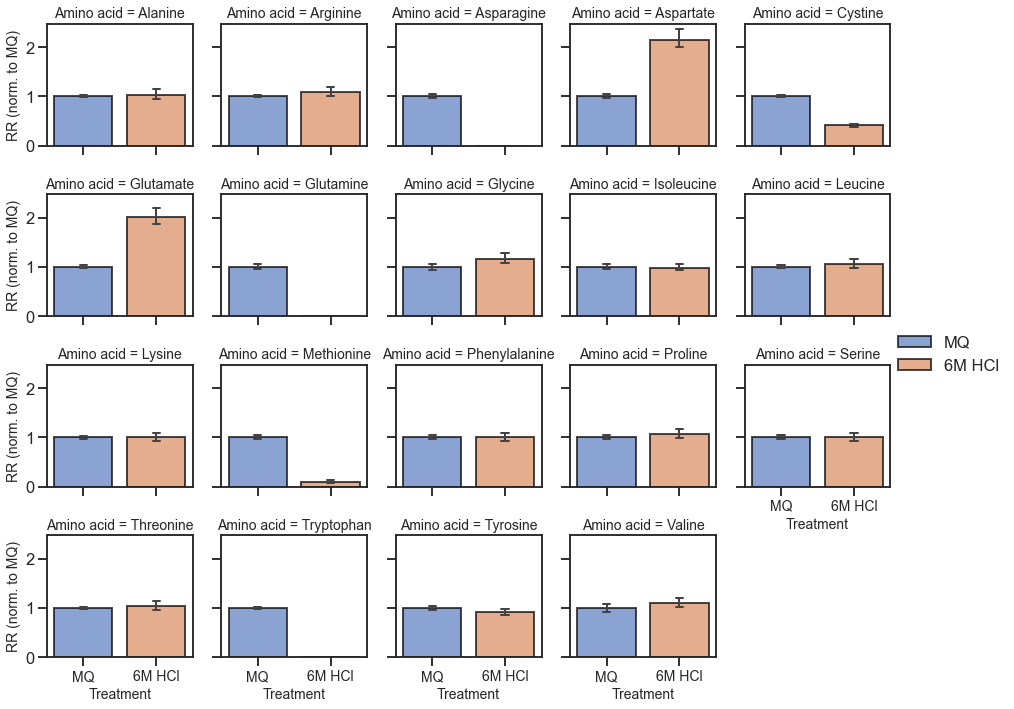

In [7]:
# Plot the data.
# Response ratio (RR) = peak area normalized to labelled standard
# Notice that Aspartate and Glutamate increases to 2x RR relative to MQ.
# This is because of a total deamination of Asparagine and Glutamine.
sns_fig = sns.FacetGrid(df_metab_flat, col='Amino acid', height=2.5, col_wrap=5, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=95, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'RR (norm. to MQ)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()
sns_fig.savefig('plots/AA_acid-hydrolysis-stability.pdf', bbox_inches='tight')

#### Conclusions
* Asparagine and Glutamine are 100% deaminated into Aspartate and Glutamate, respectively.
* Tryptophan is completely broken down during acid hydrolysis.
* Methionine and cystine are partially broken down during acid hydrolysis.
* All other amino acids are fully stable at this acid hydrolysis condition (6M HCl, 100C, 24 h, ambient air headspace).

## Looking at nucleobase stability
In this experiment the stability of nucleobases were tested under acid hydrolysis.
To 9x 1.5 mL eppendorf tubes 20 uL of 500 uM nucleobase mix (500 uM of each Guanine, Adenine, Uracil, Cytosine, Thymine and Hypoxanthine) were added. Tubes were dried and 4 were set aside as non-hydrolysis reference points. To the remainding 5 tubes 200 uL 6M HCl (Thermo: 24308) was added and incubated at 100C for 24 h before drying. No attempt was made to evacuate tubes before hydrolysis, thus ambient air was present in the headspace. Finally, all 9 tubes were reconstituted in 40 uL 80% MeOH containing U-13C, U-15N labelled amino acids at ~50 uM each (Cambridge isotopes: MSK-CAA-1) as well as a U-13C yeast extract (Cambridge isotopes: ISO1). The samples were transferred to LCMS vials and quantified on an Orbitrap in full scan mode (m/z=75-850). Peaks were integrated and manually checked in TraceFinder.

In [8]:
# Use a mask to pick out the 9 samples testing nucleobase stability:
mask = (df_RR['Exp. name'] == 'Acid stability') & (df_RR['Content'] == 'GAUCT')
df_nuc = df_RR[mask]
metab_mask = ['Buffer'] + GAUCT_keys
df_metab = df_nuc.loc[:, metab_mask]

# Normalize data to the reference (non-hydrolysis) samples:
metab_mask = ['Buffer']
for metab in GAUCT_keys:
    mask_MQ = df_metab['Buffer'] == 'MQ'
    metab_name = metab[0:-4]
    metab_MQ_mean = df_metab.loc[mask_MQ, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_MQ_mean
    metab_mask.append(metab_name)
df_metab = df_metab.loc[:, metab_mask]

# Flatten for plotting:
df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Nucleobase', 'value': 'Peak area'})

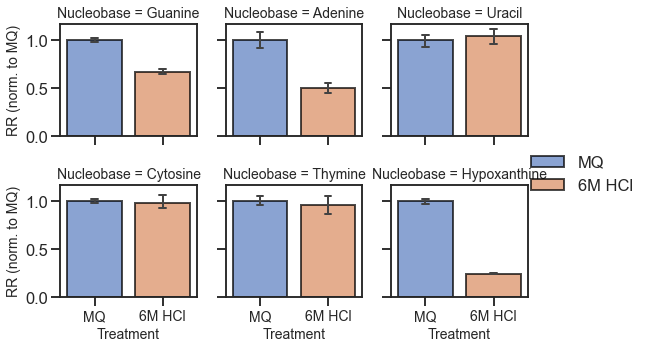

In [9]:
# Plot the data.
# Response ratio (RR) = peak area normalized to labelled standard
sns_fig = sns.FacetGrid(df_metab_flat, col='Nucleobase', height=2.5, col_wrap=3, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'RR (norm. to MQ)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()
sns_fig.savefig('plots/nucleobase-hydrolysis-stability.pdf', bbox_inches='tight')

#### Conclusions
* Pyrimidine nucleobases are fully stable at this acid hydrolysis condition (6M HCl, 100C, 24 h, ambient air headspace).
* Purine nucleobases are partially broken down during acid hydrolysis.

Purines have been found unstable at acidic conditions and breakdown of guanine and adenine happens by initial deamination to xanthine and hypoxanthine, respectively, followed by ring opening and complete degradation to produce ammonium, CO2 and the amino acid glycine. With one glycine per purine. See old literature:
* "Untersuchungen uber die chemischen Beziehungen zwischen Guanin, Xanthin, Theobromin, Caffein und Kreatinin", Adolph Strecker, 1861
* "On the hydrolysis of guanine",  George B. Y. Hunter, 1936
* "Studies in the metabolism of purines and pyrimidines by means of isotopic nitrogen", Plentl, Albert A. and Schoenheimer, Rudolf, 1944
* See numerous papers: https://paperpile.com/shared/qulbSe

### Purine degradation products
Show that purine breakdown products are produced using acid hydrolysis on a mix of nucleobases.

In [10]:
### Glycine release ###
# Use a mask to pick out the 9 samples testing nucleobase stability:
mask = (df_RR['Exp. name'] == 'Acid stability') & (df_RR['Content'] == 'GAUCT')
df_AA = df_RR[mask]
metab_mask = ['Buffer'] + AA_keys
df_metab = df_AA.loc[:, metab_mask]

# Extract amino acids for plotting:
metab_mask = ['Buffer']
for metab in AA_keys:
    metab_name = metab[0:-4]
    df_metab[metab_name] = df_metab[metab]
    metab_mask.append(metab_name)
df_metab = df_metab.loc[:, metab_mask]
# Flatten:
df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Amino acid', 'value': 'Peak area'})

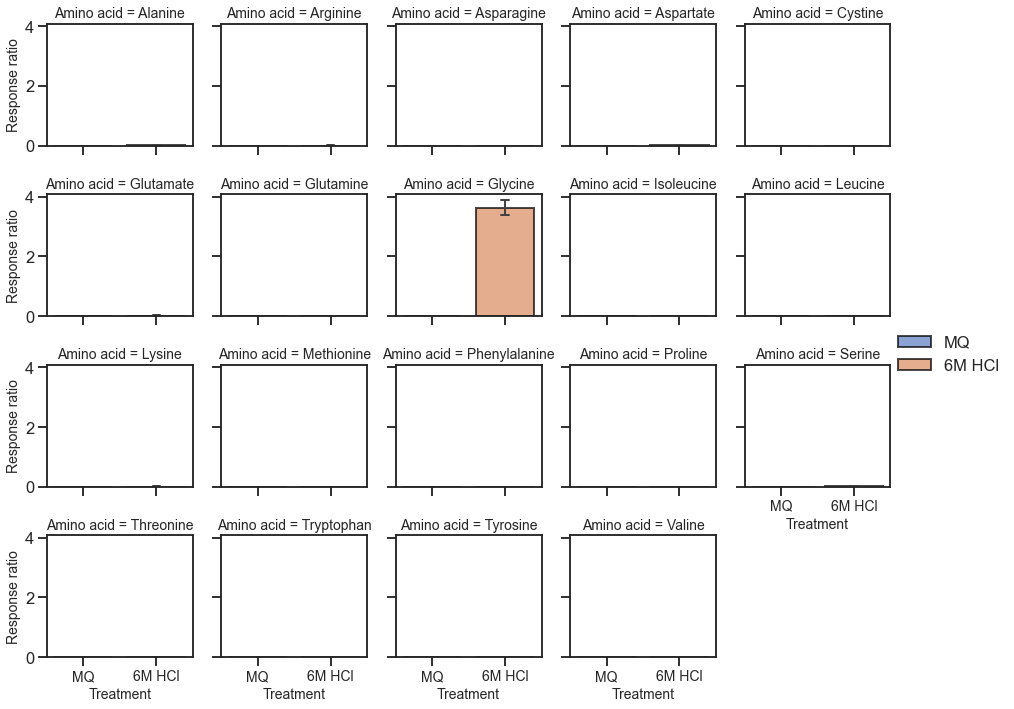

In [11]:
# Plot the data.
# Response ratio = peak area normalized to labelled standard
sns_fig = sns.FacetGrid(df_metab_flat, col='Amino acid', height=2.5, col_wrap=5, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=95, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'Response ratio', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()
sns_fig.savefig('plots/nucleobase-hydrolysis-AA-release.pdf', bbox_inches='tight')

In [12]:
### Xanthine release ###
# Use a mask to pick out the 9 samples testing nucleobase stability:
mask = (df_RR['Exp. name'] == 'Acid stability') & (df_RR['Content'] == 'GAUCT')
df_nuc = df_RR[mask]
metab_mask = ['Buffer'] + ['Uric acid neg', 'Xanthine neg']
df_metab = df_nuc.loc[:, metab_mask]

# Normalize data to the reference (non-hydrolysis) samples:
metab_mask = ['Buffer']
for metab in ['Uric acid neg', 'Xanthine neg']:
    mask_MQ = df_metab['Buffer'] == 'MQ'
    metab_name = metab[0:-4]
    metab_MQ_mean = df_metab.loc[mask_MQ, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_MQ_mean
    metab_mask.append(metab_name)
df_metab = df_metab.loc[:, metab_mask]

# Flatten for plotting:
df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Nucleobase', 'value': 'Peak area'})

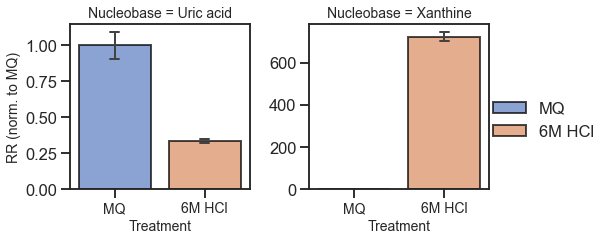

In [13]:
# Plot the data.
# Response ratio (RR) = peak area normalized to labelled standard
sns_fig = sns.FacetGrid(df_metab_flat, col='Nucleobase', height=3.5, col_wrap=2, despine=False, sharey=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'RR (norm. to MQ)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()
sns_fig.savefig('plots/nucleobase-hydrolysis-xanthine-release.pdf', bbox_inches='tight')

#### Conclusions
* Large amounts of glycine are released from purine degradation.
* Gaunine degradation causes an accumulation of xanthine.
* No signs of Uric acid (a biological purine breakdown product) release, consistent with literature on purine breakdown in acid.
* Lost purines can probably be accounted for by quantifying hypoxanthine, xanthine and glycine.

## Looking at nucleoside stability
In this experiment the stability of nucleosides were tested under acid hydrolysis.
To 9x 1.5 mL eppendorf tubes 20 uL of 500 uM nucleoside mix (500 uM of each Uridine, Deoxyuridine, Deoxythymidine, Cytidine, Deoxycytidine, Adenosine, Guanosine) were added. Tubes were dried and 4 were set aside as non-hydrolysis reference points. To the remainding 5 tubes 200 uL 6M HCl (Thermo: 24308) was added and incubated at 100C for 24 h before drying. No attempt was made to evacuate tubes before hydrolysis, thus ambient air was present in the headspace. Finally, all 9 tubes were reconstituted in 40 uL 80% MeOH containing U-13C, U-15N labelled amino acids at ~50 uM each (Cambridge isotopes: MSK-CAA-1) as well as a U-13C yeast extract (Cambridge isotopes: ISO1). The samples were transferred to LCMS vials and quantified on an Orbitrap in full scan mode (m/z=75-850). Peaks were integrated and manually checked in TraceFinder.

In [14]:
### Stability of nucleosides ###
# Use a mask to pick out the 9 samples testing nucleoside stability:
mask = (df_RR['Exp. name'] == 'Acid stability') & (df_RR['Content'] == 'Pool 14')
df_nuc = df_RR[mask]
metab_mask = ['Buffer'] + pool14_keys
df_metab = df_nuc.loc[:, metab_mask]

# Normalize data to the reference (non-hydrolysis) samples:
metab_mask = ['Buffer']
for metab in pool14_keys:
    mask_MQ = df_metab['Buffer'] == 'MQ'
    metab_name = metab[0:-4]
    metab_MQ_mean = df_metab.loc[mask_MQ, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_MQ_mean
    metab_mask.append(metab_name)
df_metab = df_metab.loc[:, metab_mask]
# Flatten for plotting:
df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Nucleosides', 'value': 'Peak area'})

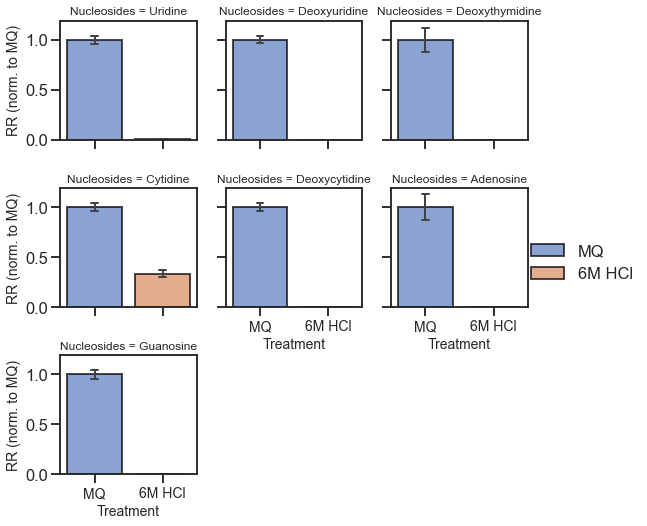

In [15]:
# Plot the data.
# Response ratio (RR) = peak area normalized to labelled standard
col_order = ['Uridine', 'Deoxyuridine', 'Deoxythymidine', 'Cytidine', 'Deoxycytidine', 'Adenosine', 'Guanosine']
sns_fig = sns.FacetGrid(df_metab_flat, col='Nucleosides', height=2.5, col_wrap=3, despine=False, col_order=col_order)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'RR (norm. to MQ)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=12)
sns_fig.add_legend()
sns_fig.savefig('plots/nucleoside-hydrolysis-stability.pdf', bbox_inches='tight')

In [16]:
### Release of nucleobases ###
# Use a mask to pick out the 9 samples testing nucleoside stability:
mask = (df_RR['Exp. name'] == 'Acid stability') & (df_RR['Content'] == 'Pool 14')
df_nuc = df_RR[mask]
metab_mask = ['Buffer'] + nucl_breakdown_keys
df_metab = df_nuc.loc[:, metab_mask]

# Normalize data to the reference hydrolysis samples:
metab_mask = ['Buffer']
for metab in nucl_breakdown_keys:
    mask_MQ = df_metab['Buffer'] == '6M HCl'
    metab_name = metab[0:-4]
    metab_MQ_mean = df_metab.loc[mask_MQ, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_MQ_mean
    metab_mask.append(metab_name)
df_metab = df_metab.loc[:, metab_mask]
# Flatten for plotting:
df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Nucleobases', 'value': 'Peak area'})

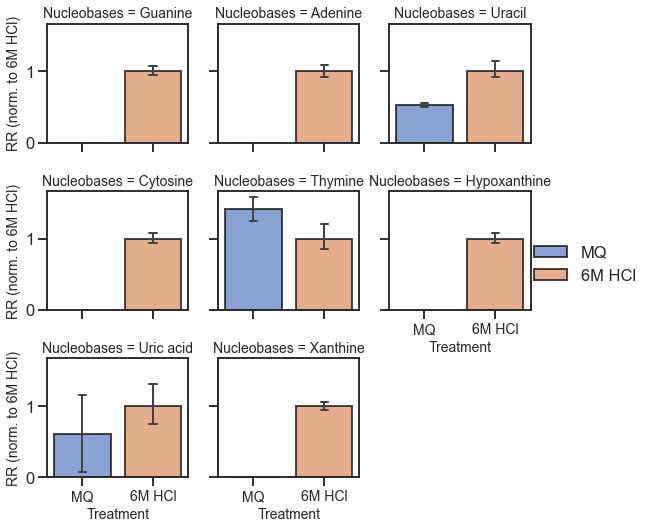

In [17]:
# Plot the data.
# Response ratio (RR) = peak area normalized to labelled standard
sns_fig = sns.FacetGrid(df_metab_flat, col='Nucleobases', height=2.5, col_wrap=3, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'RR (norm. to 6M HCl)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()
sns_fig.savefig('plots/nucleoside-hydrolysis-nucleobase-release.pdf', bbox_inches='tight')

#### Conclusions
* All nucleosides, except cytidine, are fully degraded under acid hydrolysis.
* Nucleosides are degraded to nucleobases by hydrolysis of the ribose-nucleobase glycosidic bond.
* Deoxythymidine and thymine have identical retention times and large amounts of in-source fragmentation generates thymine from deoxythymidine. This makes it appear that thymine is present at larger amounts in the non-hydryloysis reference samples vs. the the hydrolysis samples.
* Similar to thymine-deoxythymidine, uracil and deoxyuracil have identical retention times and in-source fragmentation.

## Can enzyme digestion be used to quantify nucleoside on cell material?
To quantify DNA/RNA from cell material it may be possible to use an enzyme mix to digest the DNA/RNA to individual nucleosides. Then quantification can be performed usign LCMS. To try this I use 80% MeOH to harvest cell material. This should permeate the plasma membrane and denature proteins and thus make DNA/RNA accesible to nucleases. I then use the NEB Nucleoside Digestion Mix (NEB: M0649S) to digest the cell material.

Assuming 1e7 HeLa cells on confluent 10 cm dish. 400 pg biomass per cell = 4 mg biomass. Assuming RNA/DNA is 10% of biomass = 0.4 mg RNA/DNA (see https://www.thermofisher.com/us/en/home/references/ambion-tech-support/rna-tools-and-calculators/macromolecular-components-of-e.html). Harvested such confluent HeLa dish and pooled the washings at a final volume of 10 mL (0.04 ug/uL). After mixing, aliquoted 500 uL to 8 eppendorf tubes and dried these down. Tubes were then reconstituted in 49 uL of either MilliQ water (MQ), reaction buffer (RB) as recieved with enzyme mix, 10 mM NH4Ac or 100 mM NH4Ac (same pH as reaction buffer), in duplicates. Then 1 uL enzyme mix was added and tubes were incubated 2 days in a 37C incubator.

The reaction was stopped by adding 300 uL 100% MeOH. Then tubes were vortexed and put in freezer for 1h. Then spun down and 250 uL was carefully transferred to a fresh tube. The pellet was washed with 250 uL 80% MeOH five times after this to remove all liberated nucleosides. All the washings were pooled and dried down before beimng reconstituted in 100 uL 80% MeOH and transferred to LCMS vials ("Enzyme samples").

The leftover pellet was dried and subject to acid hydrolysis using 200 uL 6M HCl and incubation overnight at 100C. The next day samples were dried and reconstituted with 100 uL 80% MeOH. After freezing for 1h, then spun down, the supernatant was moved to LCMS vials ("Acid" samples).

Samples were quantified on an Orbitrap in full scan mode (m/z=75-850). Peaks were integrated and manually checked in TraceFinder.

In [18]:
# Use a mask to pick out the samples:
mask = (df_R['Exp. name'] == 'Enzyme/acid hydrolysis')
df_nuc = df_R[mask]
nucleoside_keys = pool14_keys + ['Inosine pos']
metab_mask = ['Buffer', 'Hydrolysis'] + nucleoside_keys + nucl_breakdown_keys
df_metab = df_nuc.loc[:, metab_mask]

# Normalize to the maximum peak area:
metab_mask = ['Buffer', 'Hydrolysis']
for metab in nucleoside_keys + nucl_breakdown_keys:
    metab_name = metab[0:-4]
    metab_max = df_metab[metab].max()
    df_metab[metab_name] = df_metab[metab] / metab_max
    metab_mask.append(metab_name)
df_metab = df_metab.loc[:, metab_mask]
# Flatten for plotting:
df_metab_flat = pd.melt(df_metab, id_vars=['Buffer', 'Hydrolysis']).rename(columns={'variable': 'Metabolite', 'value': 'Peak area'})

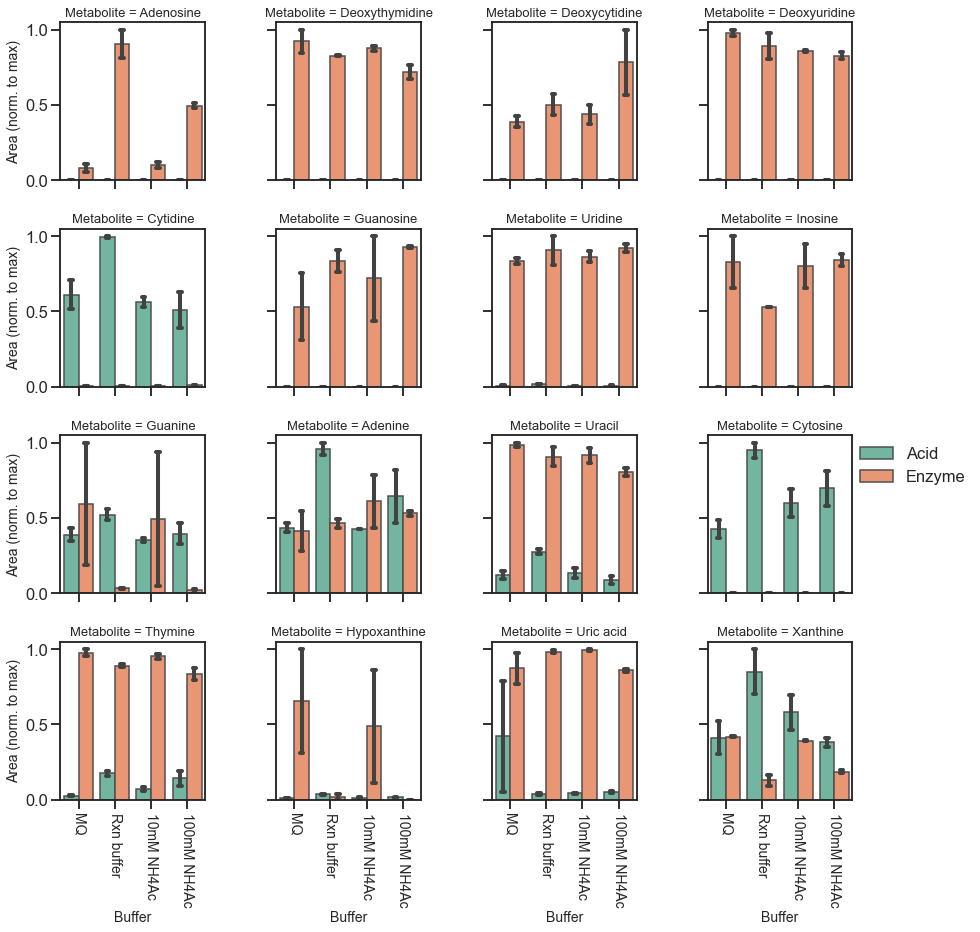

In [19]:
# Plot the data:
sns_fig = sns.FacetGrid(df_metab_flat, col='Metabolite', height=3, col_wrap=4, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Hydrolysis', capsize=.1, dodge=True, palette='Set2', edgecolor='.3')
sns_fig.add_legend()
sns_fig.set_xticklabels(rotation=-90)
sns_fig.set_axis_labels('Buffer', 'Area (norm. to max)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=13)
sns_fig.savefig('plots/enzymatic-digestion.pdf', bbox_inches='tight')

#### Conclusions
* The enzyme mix liberates a large amount of nucleosides.
* The reaction buffer (RB) works best with the enzyme mix and does not appear to have any substantial nagative effect on the LCMS quantification.
* If the enzyme had run to completion the acid hydrolysis samples ("Acid" in legend) should contain no nucleosides or nucleobases.
* The acid hydrolyzed sample did contain nucleoside and nucleobases. Cytidine and cytosine appear to be especially enriched in the "Acid" samples, indicating that the enzyme mix it not effectively liberating all cytidines.
* As the "Enzyme" samples did not appear to liberate all nucleosides after 2 days of incubation it is unlikely to be usefull for accurate quantification.

## Acid hydrolysis to quantify total purines and pyrimidines in cell material
Instead of enzymatic breakdown optimize acid hydrolysis to quantify DNA/RNA from cell material. First harvest cell material from confluent 143B dish using 80% MeOH. Transfer to tube and wash thrice to transfer all cell material. Thoroughly mix and then aliquot to fresh tube. Dry and start acid hydrolysis using 200 uL 6M HCl. Incubation overnight at 100C. No attempt was made to evacuate tubes before hydrolysis, thus ambient air was present in the headspace. The next day samples were dried and reconstituted with 100 uL 80% MeOH. After freezing for 1h, then spun down, the supernatant was moved to LCMS vials. Samples were quantified on an Orbitrap in full scan mode (m/z=75-850). Peaks were integrated and manually checked in TraceFinder.

Because some amino acids and nucleo(sides/bases) have a low solubility, start by testing a range of cell material amounts to test for compound saturation. This is done by aliquoting the equivalent of 30, 5, 1, 0.2 and 0.05 % of the total cell material on a confluent 10 cm dish with 143B cells. These aliquots are then used for acid hydrolysis.

In [20]:
# Use a mask to pick out the samples:
mask = df_R['Exp. name'] == 'Cell hydrolysis gradient'
df_cell = df_R[mask]
AA_short_keys = ['Alanine pos', 'Arginine pos', 'Aspartate neg', 'Glutamate neg', 'Lysine pos', 'Phenylalanine pos', 'Proline pos', 'Serine neg', 'Threonine pos', 'Valine pos']
metab_keys = ['Cytidine pos', 'Uridine neg'] + GAUCT_keys + ['Xanthine neg'] + AA_short_keys
metab_mask = ['Amount'] + metab_keys
df_metab = df_cell.loc[:, metab_mask]

metab_mask = ['Amount']
# Masks for amino acid and nucleo(side/base) plotting separately:
metab_mask_AA = ['Amount']
metab_mask_base = ['Amount']
# Normalize to the maximum peak area:
for metab in metab_keys:
    metab_name = metab[0:-4]
    if metab in AA_short_keys:
        metab_mask_AA.append(metab_name)
    elif metab in ['Cytidine pos', 'Uridine neg']+GAUCT_keys+['Xanthine neg']:
        metab_mask_base.append(metab_name)
    metab_max = df_metab[metab].max()
    if metab_max == 0:
        df_metab[metab_name] = df_metab[metab]
    else:
        df_metab[metab_name] = df_metab[metab] / metab_max
    metab_mask.append(metab_name)
# Flatten for plotting:
df_metab = df_metab.loc[:, metab_mask]
df_metab_flat = pd.melt(df_metab, id_vars=['Amount']).rename(columns={'variable': 'Metabolite', 'value': 'Peak area'})

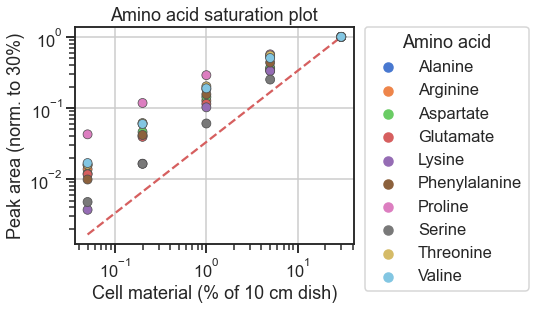

In [21]:
# Plot the data:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
mask = df_metab_flat['Metabolite'].isin(metab_mask_AA)
g1 = sns.scatterplot(ax=ax1, data=df_metab_flat[mask], y='Peak area', x='Amount', hue='Metabolite', edgecolor='.3', zorder=3)
g1.set(xscale='log', yscale='log')
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Amino acid');
g1.grid(True)
g1.set_xlabel('Cell material (% of 10 cm dish)')#, size=12);
g1.set_ylabel('Peak area (norm. to 30%)')#, size=12);
g1.set_title('Amino acid saturation plot');
prop_x = np.linspace(0.05, 30, 1000)/30
prop_y = np.linspace(0.05, 30, 1000)
ax1.plot(prop_y, prop_x, color='r', linestyle='dashed', zorder=2);
fig.savefig('plots/acid-hydrolysis_AA-saturation.pdf', bbox_inches='tight')

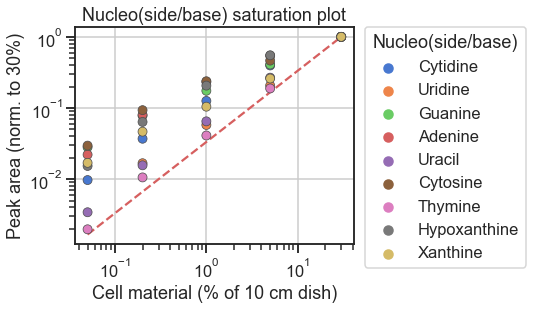

In [22]:
# Plot the data:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
mask = df_metab_flat['Metabolite'].isin(metab_mask_base)
g1 = sns.scatterplot(ax=ax1, data=df_metab_flat[mask], y='Peak area', x='Amount', hue='Metabolite', edgecolor='.3', zorder=3)
g1.set(xscale='log', yscale='log')
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Nucleo(side/base)');
g1.grid(True)
g1.set_xlabel('Cell material (% of 10 cm dish)')#, size=12);
g1.set_ylabel('Peak area (norm. to 30%)')#, size=12);
g1.set_title('Nucleo(side/base) saturation plot');
prop_x = np.linspace(0.05, 30, 1000)/30
prop_y = np.linspace(0.05, 30, 1000)
ax1.plot(prop_y, prop_x, color='r', linestyle='dashed', zorder=2);
fig.savefig('plots/acid-hydrolysis_nucl-saturation.pdf', bbox_inches='tight')

#### Conclusions
* Results are similar for amino acids and nucleo(sides/bases).
* The red line is the expected peak area based on linear extrapolation from the 30% cell material peak.
* All peak areas are above the extrapolation expectation. This indicates ion supression.
* The peak areas are substantially larger at 30% vs 5% cell material. This means that no amino acid or nucleo(side/base) is saturated at 5% cell material.

## Correcting for ion suppression with isotopically labelled internal standards
The above saturation analysis showed clear signs of ion suppression. To account for this we can use isotopically labelled internal standards. Here I use U-13C yeast extract (Cambridge isotopes: ISO1) to normalize peak areas.

In [23]:
### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('nucleotide-digest_acid-hydrolysis_09_18-dec_06-jan.xlsx', sheet_name=None)
metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-15N' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # Calculate response ratio:
        metab_dict_mes[k]['Response Ratio'] = (metab_dict_mes[k]['Response'] / metab_dict_mes[k]['ISTD Response']).replace(np.inf, 0).replace(np.nan, 0)
        # Add annotations:
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-2] + '_' + fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'ISTD Response', 'Flag Details'], axis=1)

# Extract response (unnormalized peak area):
df_R_U13 = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df_R_U13['Sample_name']))
    df_R_U13[nam] = metab_dict_mes[nam]['Response']

In [24]:
# Use a mask to pick out the samples,
# only up to what we know as unsaturated i.e. excluding the 30% cell material:
mask = (df_R_U13['Exp. name'] == 'Cell hydrolysis gradient') & (df_R_U13['Amount'] != 30)
df_cell = df_R_U13[mask]
metab_keys = ['Alanine pos', 'Arginine pos', 'Aspartate neg', 'Glutamate neg', 'Lysine pos', 'Proline pos', 'Serine neg', 'Threonine pos', 'Valine pos']
metab_mask = ['Amount'] + metab_keys
df_metab = df_cell

# Normalize first to the U-13C internal standard
# then to the maximum peak area:
metab_mask = ['Amount']
for metab in metab_keys:
    metab_name = metab[0:-4]
    df_metab[metab] = df_metab[metab] / df_metab['{}'.format(metab[0:-4] + ' U-13C' + metab[-4:len(metab)])]
    metab_max = df_metab[metab].max()
    if metab_max == 0:
        df_metab[metab_name] = df_metab[metab]
    else:
        df_metab[metab_name] = df_metab[metab] / metab_max
    metab_mask.append(metab_name)
# Flatten for plotting:
df_metab = df_metab.loc[:, metab_mask]
df_metab_flat = pd.melt(df_metab, id_vars=['Amount']).rename(columns={'variable': 'Metabolite', 'value': 'Peak area'})

<ipython-input-24-e7ecf0b756fa>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metab[metab] = df_metab[metab] / df_metab['{}'.format(metab[0:-4] + ' U-13C' + metab[-4:len(metab)])]
<ipython-input-24-e7ecf0b756fa>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metab[metab_name] = df_metab[metab] / metab_max


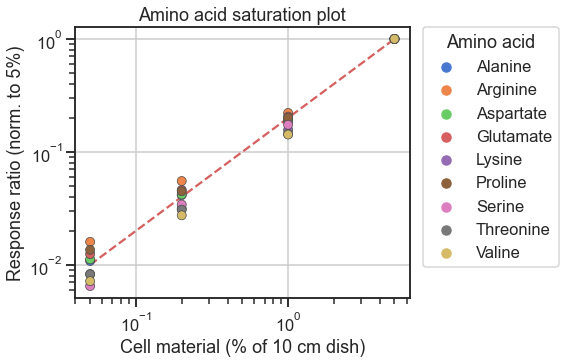

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
g1 = sns.scatterplot(ax=ax1, data=df_metab_flat, y='Peak area', x='Amount', hue='Metabolite', edgecolor='.3', zorder=3)
g1.set(xscale='log', yscale='log')
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Amino acid');
g1.grid(True)
g1.set_xlabel('Cell material (% of 10 cm dish)')#, size=12);
g1.set_ylabel('Response ratio (norm. to 5%)')#, size=12);
g1.set_title('Amino acid saturation plot');
prop_x = np.linspace(0.05, 5, 1000)/5
prop_y = np.linspace(0.05, 5, 1000)
ax1.plot(prop_y, prop_x, color='r', linestyle='dashed', zorder=2);
fig.savefig('plots/acid-hydrolysis_AA-saturation_RR.pdf', bbox_inches='tight')

#### Conclusions
* There is a linear relationship between response ratio (as calculated from peak area normalized to an internal standard) and %dish cell material.
* Internal standards mitigate ion suppression.
* The linear relationship further verifies that no amino acids have been saturated.

## Testing reproducibility of quantification from cell material using acid hydrolysis
Here I want to test the reproducibility of the acid hydrolysis protocol described above. To do this, I made 4 separate aliquots and ran the full acid hydrolysis protocol on these in paralelle.

In [26]:
# Use a mask to pick out the samples:
mask = (df_R['Exp. name'] == 'DNA vs. cell acid hydrolysis') & (df_R['Content'] == 'Cells')
df_metab = df_R[mask]
AA_stable_keys = ['Alanine pos', 'Arginine pos', 'Aspartate neg', 'Glutamate neg', 'Glycine neg', 'Isoleucine pos', 'Leucine pos', 'Lysine pos', 'Phenylalanine pos', 'Proline pos', 'Serine neg', 'Threonine pos', 'Tyrosine pos', 'Valine pos']
metab_keys = AA_stable_keys + GAUCT_keys + ['Xanthine neg']

# Normalize to the first sample:
metab_mask = list()
for metab in metab_keys:
    metab_name = metab[0:-4]
    metab_mean = df_metab[metab].values[0]
    if df_metab[metab].min() > 0:
        df_metab[metab_name] = 100 - (df_metab[metab] / metab_mean *100)
        metab_mask.append(metab_name)
# Flatten for plotting:
df_metab = df_metab.loc[:, metab_mask]
df_metab_flat = pd.melt(df_metab).rename(columns={'variable': 'Metabolite', 'value': 'Deviation'})

<ipython-input-26-c3cb61283567>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metab[metab_name] = 100 - (df_metab[metab] / metab_mean *100)


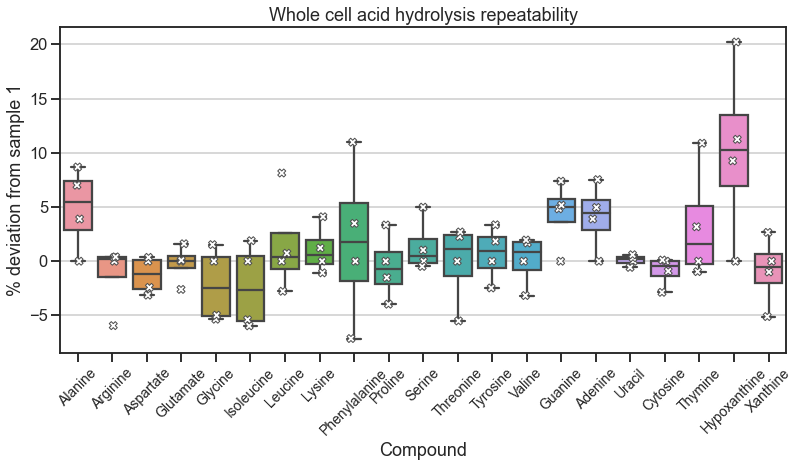

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize=(13, 6))
g1 = sns.boxplot(ax=ax1, data=df_metab_flat, x='Metabolite', y='Deviation', fliersize=0)
g2 = sns.stripplot(ax=ax1, data=df_metab_flat, x='Metabolite', y='Deviation', jitter=True, dodge=True, linewidth=1, color='1', edgecolor='.3', marker='X', s=8)
g1.set_xticklabels(labels=g1.get_xticklabels() , rotation=45, size=14);
g1.set_xlabel('Compound', size=18);
g1.set_ylabel('% deviation from sample 1', size=18);
g1.set_title('Whole cell acid hydrolysis repeatability', size=18);
g1.grid(True, axis='y')
fig.savefig('plots/acid-hydrolysis_repeatability.pdf', bbox_inches='tight')

#### Conclusions
* The deviation is roughly centered around 0.
* The deviation is mostly below 5%.
* Repeatability is good.

## Random analysis

### Protein release from nucleobase/nucleoside pools could be protein contamination

In [28]:
### Show appearance of amino acids after acid incubation correlates between samples ###
mask = (df_R['Buffer'] == '6M HCl') & ( (df_R['Content'] == 'GAUCT') |  (df_R['Content'] == 'Pool 14') | (df_R['Content'] == 'DNA') )
df_AA = df_R[mask]

metab_mask = ['Content'] + AA_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Content']
for metab in AA_keys:
    if metab == 'Glycine neg':
        continue
    metab_name = metab[0:-4]
    df_metab[metab_name] = df_metab[metab]
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

for idx in df_metab.index.values:
    mv = df_metab.loc[idx, metab_mask[1:]].values.max()
    df_metab.loc[idx, metab_mask[1:]] = df_metab.loc[idx, metab_mask[1:]] / mv

df_metab_flat = pd.melt(df_metab, id_vars=['Content']).rename(columns={'variable': 'Amino acid', 'value': 'Peak area'})

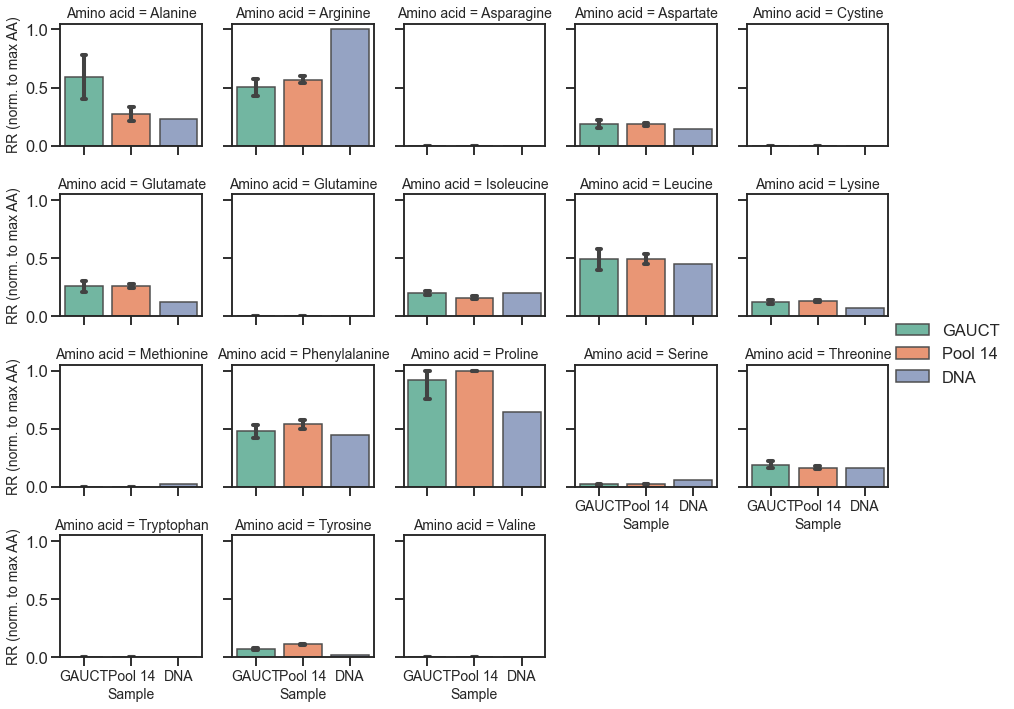

In [29]:
sns_fig = sns.FacetGrid(df_metab_flat, col='Amino acid', height=2.5, col_wrap=5, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Content', y='Peak area', ci=90, hue='Content', capsize=.1, dodge=False, palette='Set2', edgecolor='.3')
sns_fig.add_legend()
sns_fig.set_axis_labels('Sample', 'RR (norm. to max AA)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)

In [30]:
df_metab_flat['new_key'] = df_metab_flat['Content'] + df_metab_flat['Amino acid']
aggregation_functions = {'Content': 'first', 'Amino acid': 'first', 'Peak area': 'mean'}
df_metab_flat_agg = df_metab_flat.groupby(df_metab_flat['new_key']).aggregate(aggregation_functions)

x = list(df_metab_flat_agg[df_metab_flat_agg['Content'] == 'DNA']['Peak area'].values)*2
y1 = list(df_metab_flat_agg[df_metab_flat_agg['Content'] == 'GAUCT']['Peak area'].values)
y2 = list(df_metab_flat_agg[df_metab_flat_agg['Content'] == 'Pool 14']['Peak area'].values)
names = ['GAUCT']*18 + ['Pool 14']*18

df_plot = pd.DataFrame(list(zip(names, x, y1+y2)), columns =['Pool', 'x', 'y'])

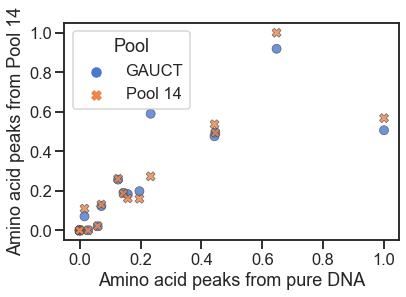

In [31]:
sns_fig = sns.scatterplot(x='x', y='y', data=df_plot, hue='Pool', alpha=0.8, markers=True, style='Pool', edgecolor='.3')
sns_fig.set(xlabel='Amino acid peaks from pure DNA', ylabel='Amino acid peaks from Pool 14');